# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (8, 6)

from matplotlib import colors
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel(r'C:\Users\Urmas\Desktop\geo_comment.xlsx', sheet_name='Sheet1', 
                     usecols=['x', 'y', 'comment_class', 'multiplier', 'comment'], header=0)
data

x          y  comment_class  multiplier  \
0      37.612416  55.777454             -1           1   
1      37.612416  55.777454             -1           1   
2      37.603298  55.742108             -1           1   
3      37.558526  55.728758             -1           1   
4      37.566431  55.731794             -1           1   
...          ...        ...            ...         ...   
70377  37.454528  55.792331             -1           1   
70378  37.384325  55.899068             -1           1   
70379  37.421066  55.848756              1           1   
70380  37.448509  55.793065             -1           1   
70381  37.451249  55.836620             -1           1   

                                                 comment  
0      Во все разделы правил землепользования и застр...  
1      На основании вступившего в законную силу судеб...  
2      Внести в Проект правил землепользования и заст...  
3      Учитывая социальную значимость проекта строите...  
4      Учитывая социальную значимость проекта строите...  
...                                                  ...  
70377  Не поддерживаю. Я против строительства многоэт...  
70378  Не поддерживаю. Не нужны отстойники автобусов ...  
70379  Не поддерживаю. На мой взгляд, необходимо искл...  
70380  Не поддерживаю: нарушения при  строительстве н...  
70381  Не поддерживаю. Выступаю против застройки бере...  

[70382 rows x 5 columns]

In [5]:
X = pd.DataFrame(data['x'])
Y = pd.DataFrame(data['y'])
data2 = pd.DataFrame(data[['x', 'y']])

In [7]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y)
data2 = StandardScaler().fit_transform(data2)

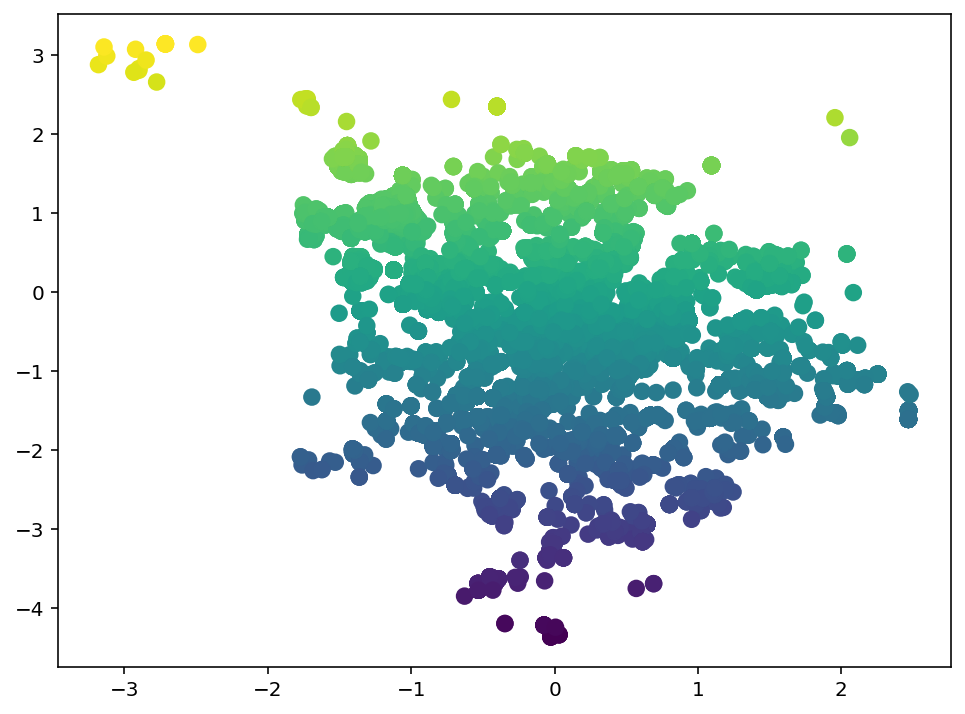

In [8]:
plt.scatter(X, Y, c=Y, s=60)

### Визуально разделим город на районы безотносительно голосов 

**KMeans**

In [26]:
from sklearn.cluster import KMeans

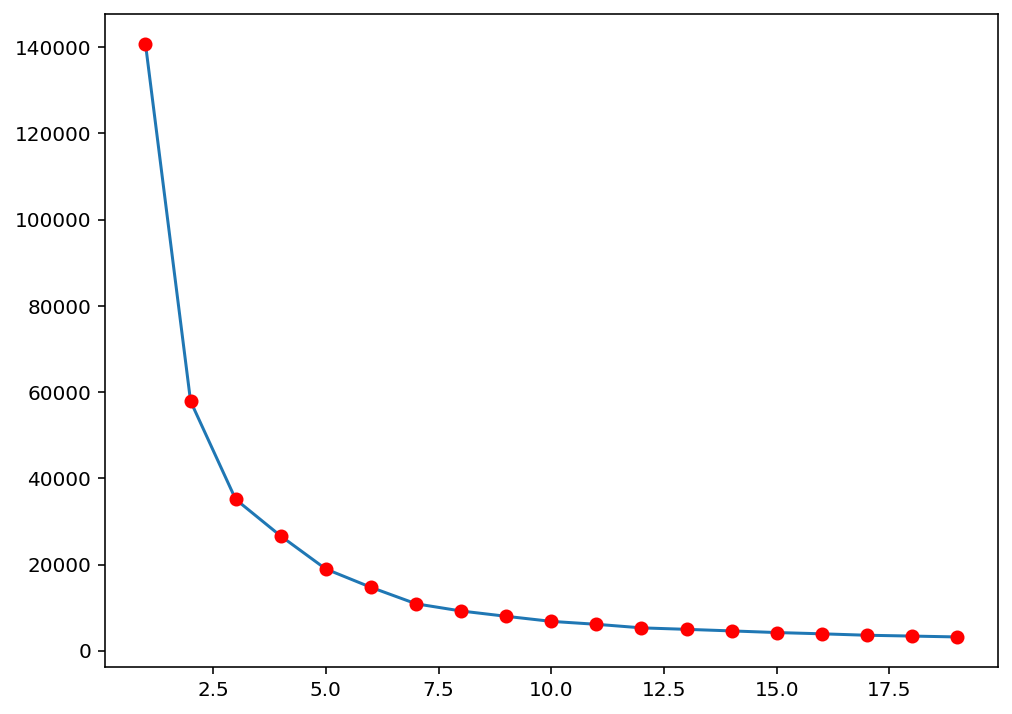

In [7]:
# строим график логтя

# создаем список для инерции
k_inertia = []
# задаем диапазон кластеров
ks=range(1, 20)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}

for k in ks:
    clf_kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    clusters_kmeans = clf_kmeans.fit_predict(data2)
    # добавляем инерцию каждой модели в список
    k_inertia.append(clf_kmeans.inertia_)
    
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia, 'ro')

In [8]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


Определить точку изгиба на кривой SSE не всегда просто. Если у вас возникли проблемы с выбором точки изгиба кривой, вы можете использовать пакет Python, kneed, для программной идентификации точки изгиба.

In [9]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 20), k_inertia, curve="convex", direction="decreasing", interp_method="polynomial") # см.параметры!
kl.elbow

# 4, 5(без interp_method="polynomial")

4

Посчитаем количество кластеров другим способом

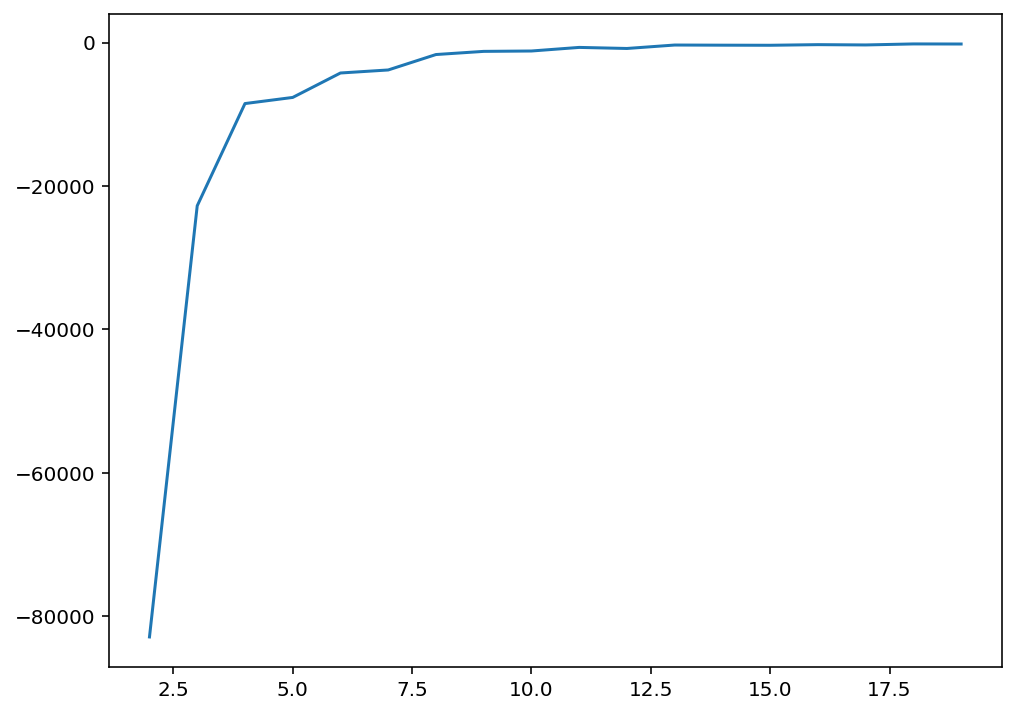

In [10]:
diff = np.diff(k_inertia)   # считаем изменения 
plt.plot(ks[1:], diff)

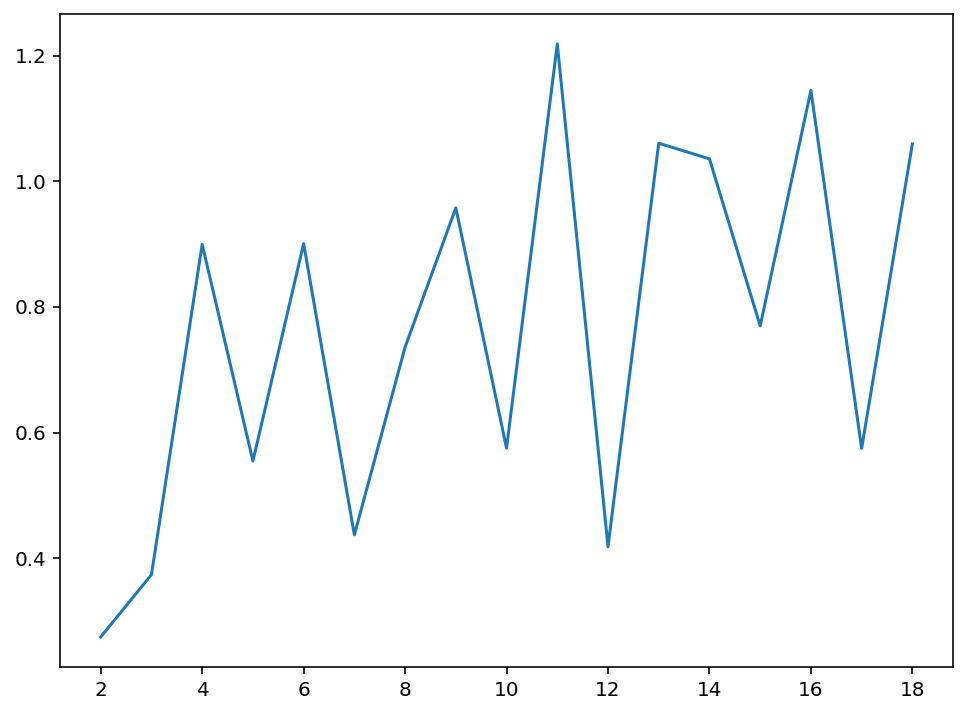

In [11]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [12]:
k_opt = ks[np.argmin(diff_r) + 1]
k_opt

2

Визуально, кластеров три-четыре-пять.

In [76]:
kmeans = KMeans(
            init='k-means++',   #['random', 'k-means++', 'ndarray'],
            n_clusters=5,
            n_init=10,  # Количество раз, когда алгоритм k-средних будет выполняться с разными начальными числами центроидов
            max_iter=300,  # Максимальное количество итераций алгоритма k-средних за один прогон
            random_state=42
            )

kmeans.fit(data2)

KMeans(n_clusters=5, random_state=42)

Статистика запуска инициализации с наименьшим значением SSE доступна как атрибуты kmeansпосле вызова .fit()

In [77]:
kmeans.inertia_  # Сумма квадратов расстояний от образцов до ближайшего центра кластера

18969.72168603101

In [78]:
kmeans.cluster_centers_   # Координаты кластерных центров

array([[ 0.89045185, -0.59145219],
       [-1.15601401,  1.24955909],
       [-0.77736674,  0.12327407],
       [-0.21195083, -1.35248543],
       [ 1.23702821,  0.51762079]])

In [79]:
kmeans.n_iter_  # Количество выполненных итераций

6

In [80]:
# назначения кластера сохраняются в виде одномерного массива NumPy в kmeans.labels_

kmeans.labels_
# порядок меток кластера может быть изменен при новой инициализации

array([0, 0, 3, ..., 1, 2, 1])

In [81]:
clusters = kmeans.predict(data2)
clusters

array([0, 0, 3, ..., 1, 2, 1])

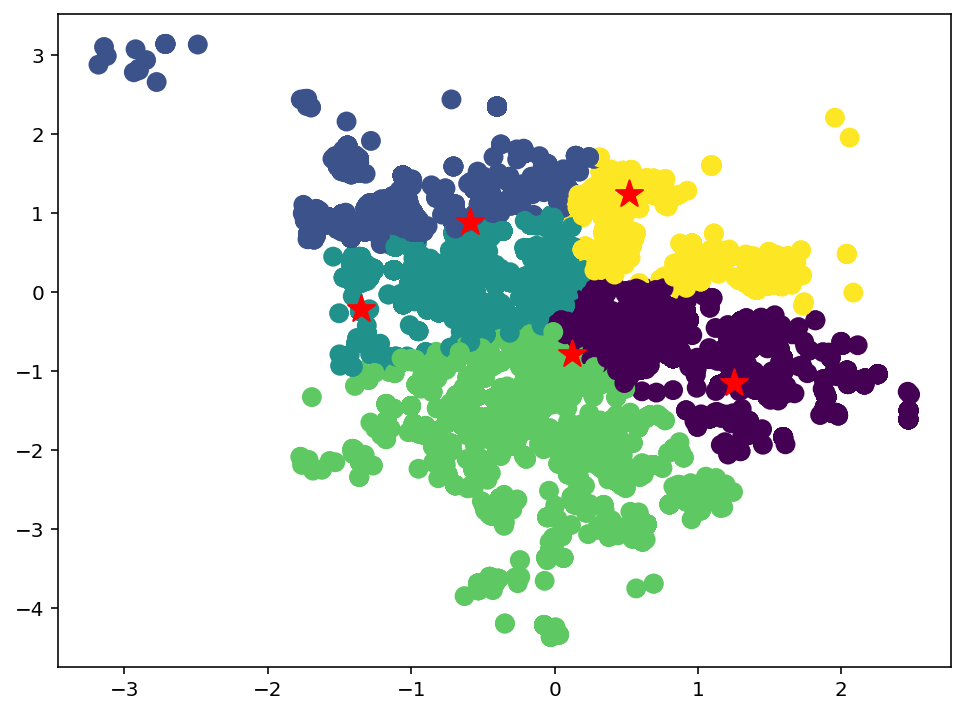

In [82]:
plt.scatter(data2[:,0], data2[:,1], c=kmeans.labels_, s=80)
#plt.scatter(data2[:,0], data2[:,1], c = clusters, s=80)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], s = 200, color='r', marker='*') # центроиды
#plt.grid()
plt.show()

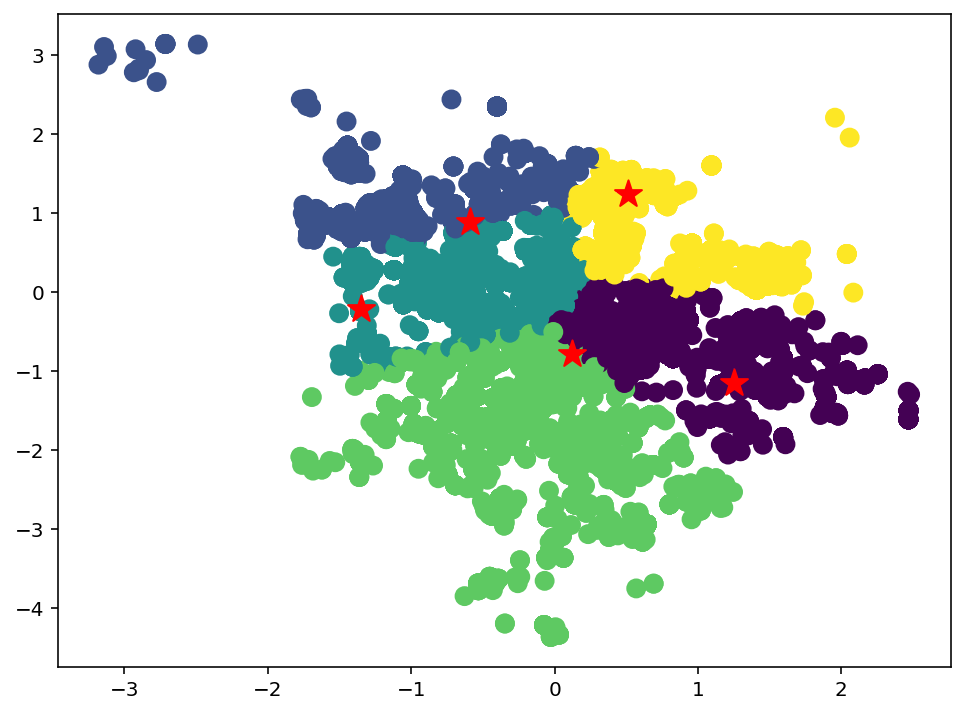

In [83]:
# посмотрим на центроиды через LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(data2, clusters)
lda.means_

plt.scatter(data2[:,0], data2[:,1], c=clusters, s=80)
plt.scatter(lda.means_[:,1], lda.means_[:,0], s = 200, color='r', marker='*') # центроиды
plt.show()

почему центроиды не в центре кластеров?

In [84]:
for i in range(5):
    print (i,'cluster =',len(data2[clusters==i]))

0 cluster = 20578
1 cluster = 17742
2 cluster = 9913
3 cluster = 12118
4 cluster = 10031


**DBSCAN**

In [19]:
from sklearn.cluster import DBSCAN

In [20]:
eps_ = np.array([0.005, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5, 0.8, 1.2, 2.0, 3.0, 5.0])
min_samples_= np.array([5, 10, 50, 100])

In [22]:
# Так как на всей выборки считать слишком долго, возьмем лишь часть
choice = np.random.choice(pd.DataFrame(data2).index, size=30000, replace=False).tolist()
data_x = data2[pd.DataFrame(data2).index.isin(choice)]

##### посмотрим в каких диапазонах стоит подбирать значения   (не тянет ПК)

for k in eps_:
    fig, axes = plt.subplots(2,5 , figsize=(15,7))
    for ax, j in zip(fig.axes ,min_samples_):
        DB = DBSCAN(eps=k, min_samples=j, n_jobs=-1 )
        DB_clusters = DB.fit_predict(data2)
        ax.scatter(data_x.x, data_x.y,  cmap='autumn', s=60)

In [26]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

clustering = DBSCAN(eps=0.2, min_samples=5).fit(data2)
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [27]:
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [28]:
n_clusters_,  n_noise_

(13, 23)

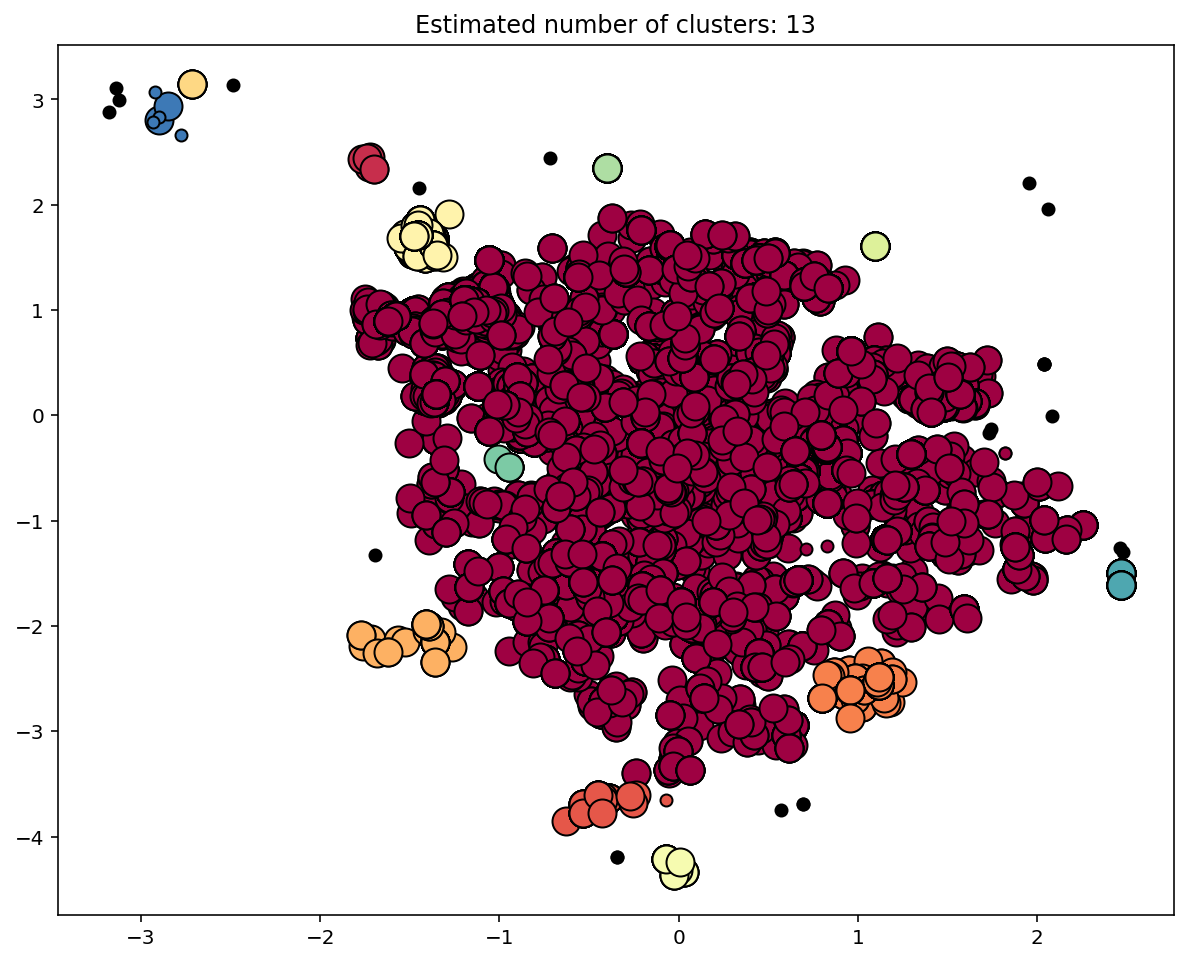

In [29]:
# Plot result
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data2[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data2[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.show()

DBSCAN справляется хуже

### Аналогично исследуем скопления голосов за и против отдельно

In [30]:
data3 = pd.DataFrame(data.comment_class)

In [31]:
data3['comment_class'].nunique()
# кластеров, очевидно, два

2

**KMeans**

In [32]:
kmeans = KMeans(
            init='k-means++',   #['random', 'k-means++', 'ndarray'],
            n_clusters=2,
            n_init=10,  # Количество раз, когда алгоритм k-средних будет выполняться с разными начальными числами центроидов
            max_iter=300,  # Максимальное количество итераций алгоритма k-средних за один прогон
            random_state=42
            )

kmeans.fit(data3)

KMeans(n_clusters=2, random_state=42)

Статистика запуска инициализации с наименьшим значением SSE доступна как атрибуты kmeansпосле вызова .fit()

In [33]:
kmeans.inertia_  # Сумма квадратов расстояний от образцов до ближайшего центра кластера

0.0

In [34]:
kmeans.cluster_centers_   # Координаты кластерных центров

array([[-1.],
       [ 1.]])

In [35]:
# назначения кластера сохраняются в виде одномерного массива NumPy в kmeans.labels_

kmeans.labels_
# порядок меток кластера может быть изменен при новой инициализации

array([0, 0, 0, ..., 1, 0, 0])

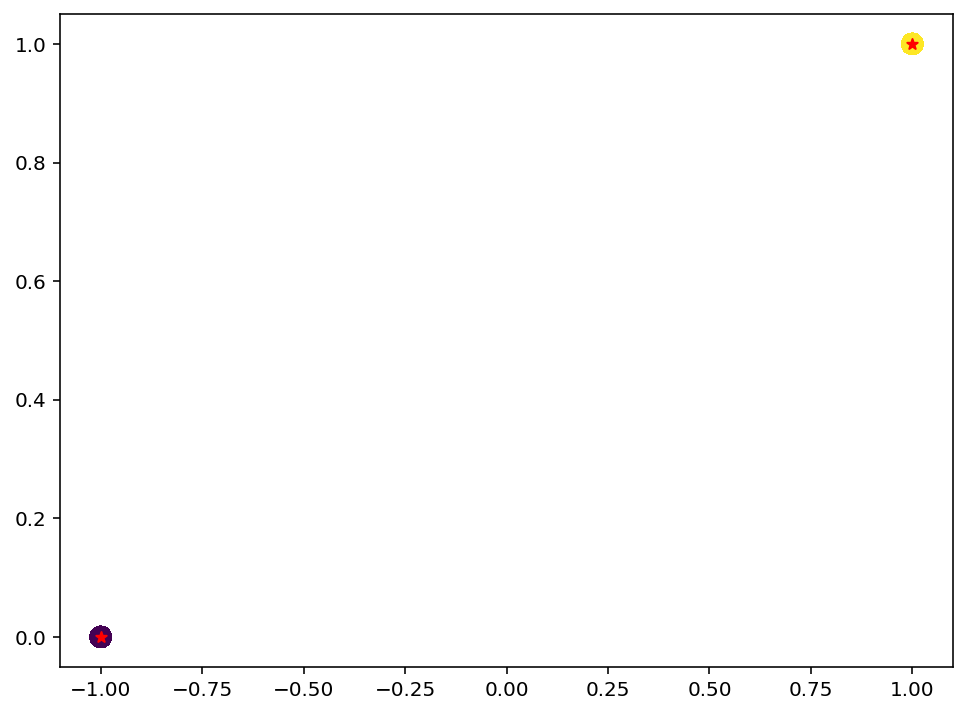

In [36]:
plt.scatter(data3, kmeans.labels_, c=kmeans.predict(data3), s=100)
plt.scatter(np.array([1, kmeans.cluster_centers_[:1]]), np.array([kmeans.cluster_centers_[1:], 0]), s = 30, color='r', marker='*') # центроиды
#plt.grid()
plt.show()

In [172]:
# Посмотрим скопления голосов "за" и "против" по районам

data_positive = data[data.comment_class == 1][['x', 'y']].reset_index()[['x', 'y']]
data_negative = data[data.comment_class  == -1][['x', 'y']].reset_index()[['x', 'y']]

data_positive = StandardScaler().fit_transform(data_positive)
data_negative = StandardScaler().fit_transform(data_negative)

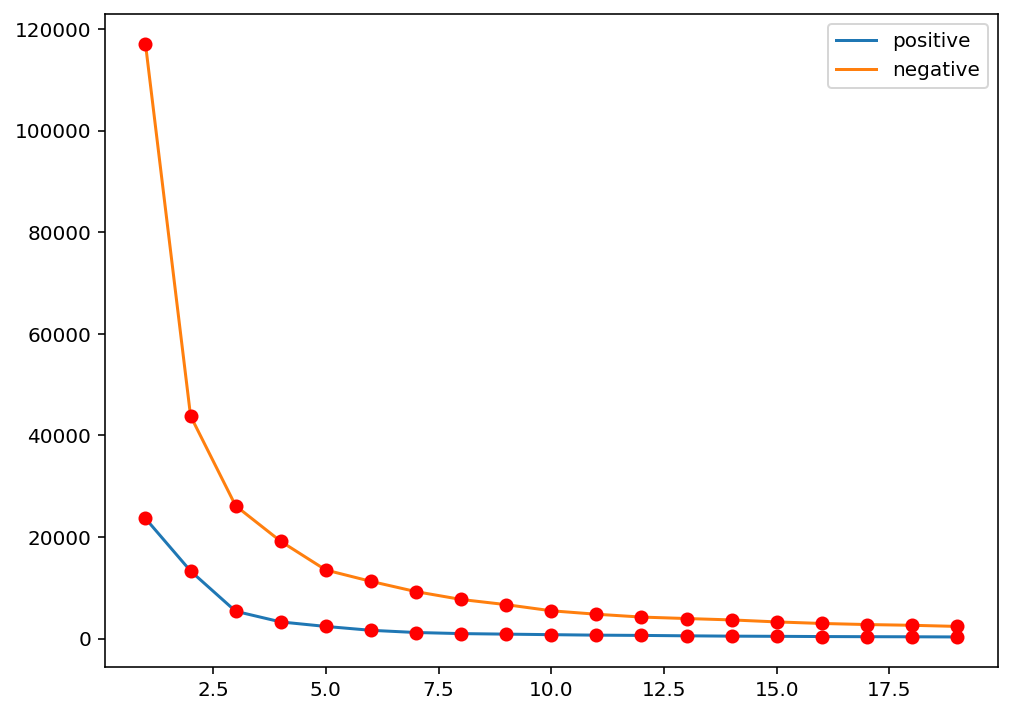

In [173]:
# строим график логтя

# создаем список для инерции
k_inertia1 = []
k_inertia2 = []
# задаем диапазон кластеров
ks=range(1, 20)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}

for k in ks:
    clf_kmeans1 = KMeans(n_clusters=k, **kmeans_kwargs)
    clf_kmeans2 = KMeans(n_clusters=k, **kmeans_kwargs)
    
    clusters_kmeans1 = clf_kmeans1.fit_predict(data_positive)
    clusters_kmeans2 = clf_kmeans2.fit_predict(data_negative)
    
    # добавляем инерцию каждой модели в список
    k_inertia1.append(clf_kmeans1.inertia_)
    k_inertia2.append(clf_kmeans2.inertia_)
    
fig, ax = plt.subplots()    

plt.plot(ks, k_inertia1, label = 'positive')
plt.plot(ks, k_inertia1, 'ro')

plt.plot(ks, k_inertia2, label = 'negative')
plt.plot(ks, k_inertia2, 'ro')

ax.legend()
plt.show()

In [196]:
# из графика логтя:
n_claster_positive = 3
n_claster_negative = 5

In [197]:
km_p = KMeans(
            init='k-means++',   #['random', 'k-means++', 'ndarray'],
            n_clusters=n_claster_positive,
            n_init=10,  # Количество раз, когда алгоритм k-средних будет выполняться с разными начальными числами центроидов
            max_iter=300,  # Максимальное количество итераций алгоритма k-средних за один прогон
            random_state=42
            )

km_p.fit(data_positive)

km_n = KMeans(
            init='k-means++',   #['random', 'k-means++', 'ndarray'],
            n_clusters=n_claster_negative,
            n_init=10,  # Количество раз, когда алгоритм k-средних будет выполняться с разными начальными числами центроидов
            max_iter=300,  # Максимальное количество итераций алгоритма k-средних за один прогон
            random_state=42
            )

km_n.fit(data_negative)

KMeans(n_clusters=5, random_state=42)

Статистика запуска инициализации с наименьшим значением SSE доступна как атрибуты kmeansпосле вызова .fit()

In [198]:
km_p.inertia_, km_n.inertia_  # Сумма квадратов расстояний от образцов до ближайшего центра кластера

(5383.67004278633, 13510.197382114577)

In [199]:
km_p.cluster_centers_   # Координаты кластерных центров

array([[ 1.13509558,  0.30888131],
       [-0.26404534, -1.1327593 ],
       [-1.06316809,  0.90798011]])

In [200]:
km_n.cluster_centers_

array([[ 1.2545767 ,  0.56687389],
       [-1.14673245,  1.24854912],
       [-0.27205623, -1.61077678],
       [ 0.89858931, -0.56675745],
       [-0.71076035,  0.13227492]])

In [201]:
km_p.n_iter_,  km_n.n_iter_# Количество выполненных итераций

(3, 4)

In [202]:
# назначения кластера сохраняются в виде одномерного массива NumPy в kmeans.labels_

km_p.labels_, km_n.labels_,
# порядок меток кластера может быть изменен при новой инициализации

(array([1, 1, 1, ..., 2, 2, 2]), array([3, 3, 3, ..., 1, 4, 1]))

In [203]:
clusters_p = km_p.predict(data_positive)
clusters_n = km_n.predict(data_negative)

clusters_p, clusters_n, 

(array([1, 1, 1, ..., 2, 2, 2]), array([3, 3, 3, ..., 1, 4, 1]))

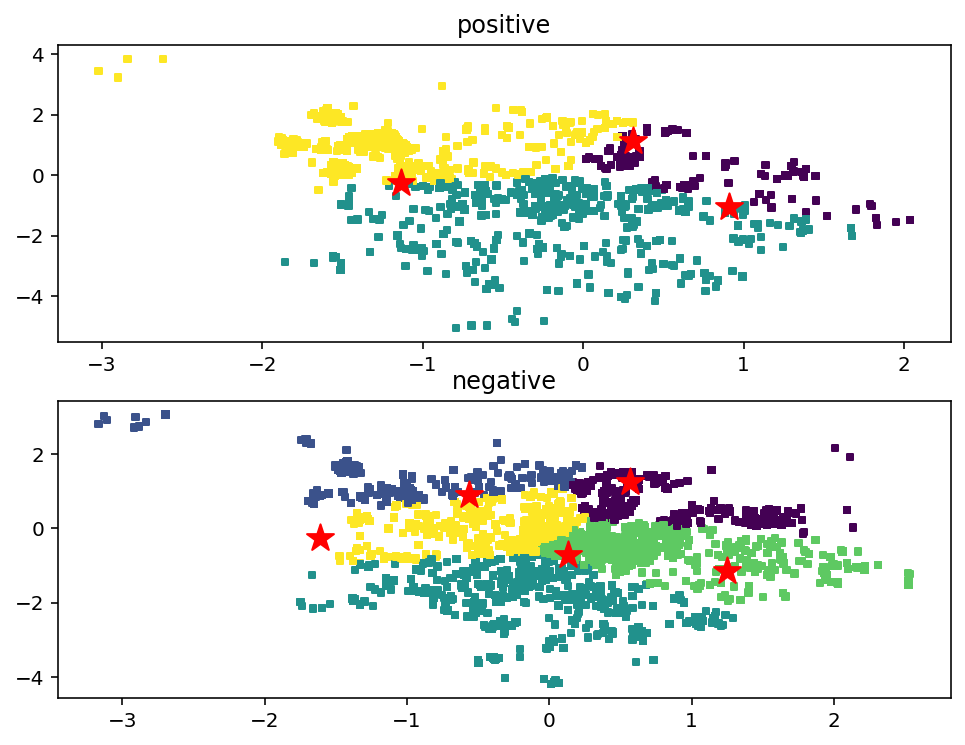

In [204]:
fig, axes = plt.subplots(2)

axes[0].scatter(data_positive[:,0], data_positive[:,1], c=clusters_p, s=10, marker='s')
axes[0].set_title('positive')
#axes[0].scatter(data2[:,0], data2[:,1], c=kmeans.labels_, s=80, alpha=0.01)
axes[0].scatter(km_p.cluster_centers_[:,1], km_p.cluster_centers_[:,0], s = 200, color='r', marker='*') # центроиды

axes[1].scatter(data_negative[:,0], data_negative[:,1], c=clusters_n, s=10, marker='s')
axes[1].set_title('negative')
axes[1].scatter(km_n.cluster_centers_[:,1], km_n.cluster_centers_[:,0], s = 200, color='r', marker='*') # центроиды



plt.show()

Кажется, голоса по районам города распределены равномерно, негативных голосов больше

Найти наиболее активные в голосовании районы (подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')

In [210]:
data4 = pd.DataFrame(data[['x', 'y', 'multiplier']])
data4

x          y  multiplier
0      37.612416  55.777454           1
1      37.612416  55.777454           1
2      37.603298  55.742108           1
3      37.558526  55.728758           1
4      37.566431  55.731794           1
...          ...        ...         ...
70377  37.454528  55.792331           1
70378  37.384325  55.899068           1
70379  37.421066  55.848756           1
70380  37.448509  55.793065           1
70381  37.451249  55.836620           1

[70382 rows x 3 columns]

In [215]:
data4['multiplier'].nunique()

76

In [224]:
# возьмем 10 максимальных значений data4['multiplier']
data_action = data4.sort_values(by=['multiplier'], ascending=[False]).head(10).reset_index().drop('index', axis=1)
data_action = StandardScaler().fit_transform(data_action)

**DBSCAN**

In [228]:
# DBSCAN
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1, min_samples=5).fit(data_action)
clustering.labels_

array([-1, -1, -1, -1,  0,  0,  0,  0,  0, -1], dtype=int64)

In [229]:
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [230]:
n_clusters_,  n_noise_

(1, 5)

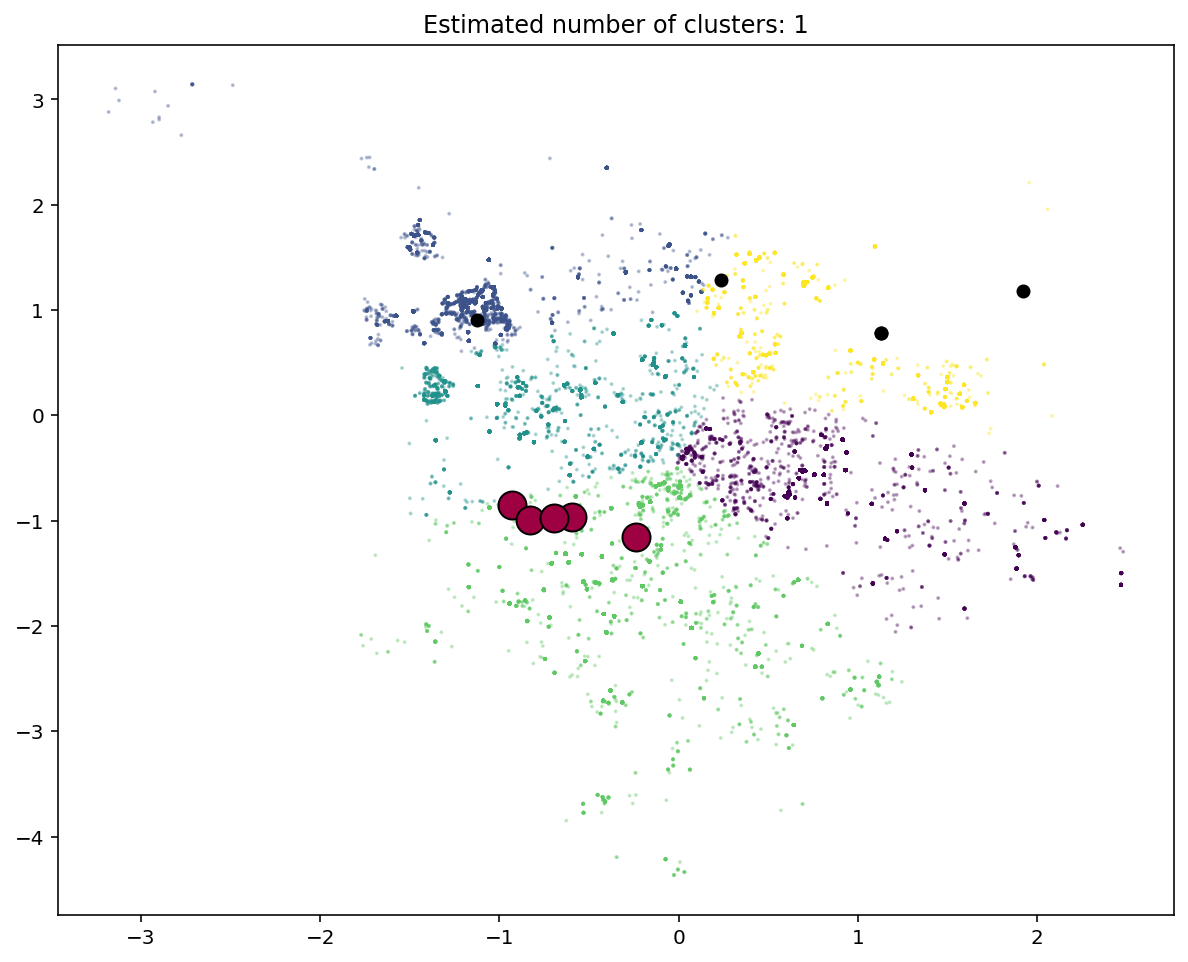

In [240]:
# Plot result
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data_action[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data_action[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.scatter(data2[:,0], data2[:,1], c=kmeans.labels_, s=1, alpha=0.3)
plt.show()

В данном случае выбросы (-1) - это места активных голосований в других районах

In [232]:
colo = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colo[x % len(colo)])

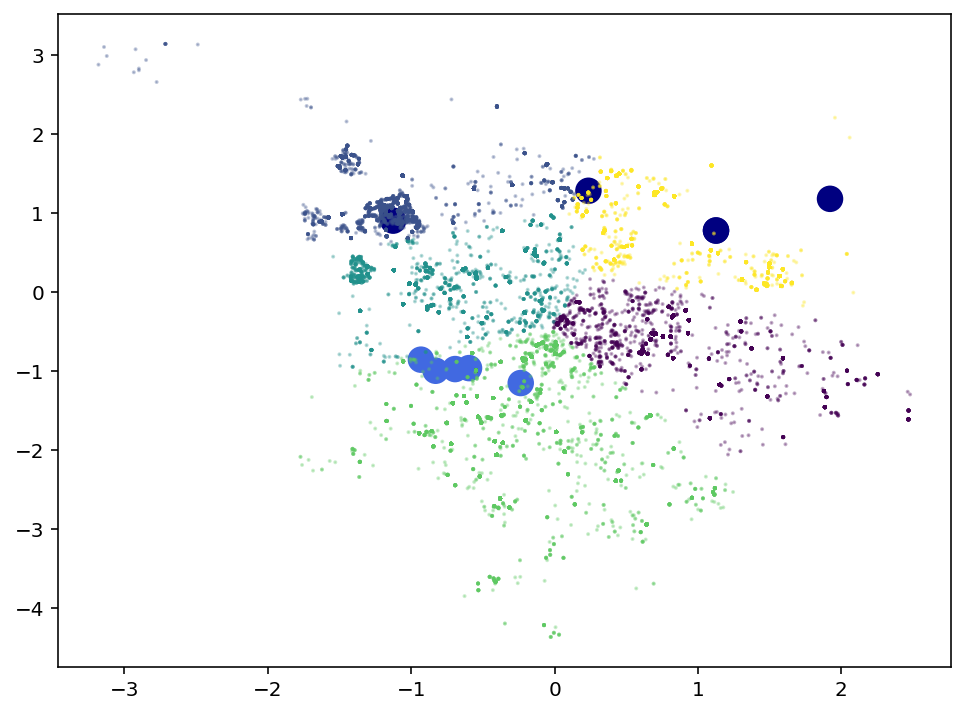

In [239]:
plt.scatter(data_action[:,0], data_action[:,1], c=vectorizer(labels), s=150)
plt.scatter(data2[:,0], data2[:,1], c=kmeans.labels_, s=1, alpha=0.3)

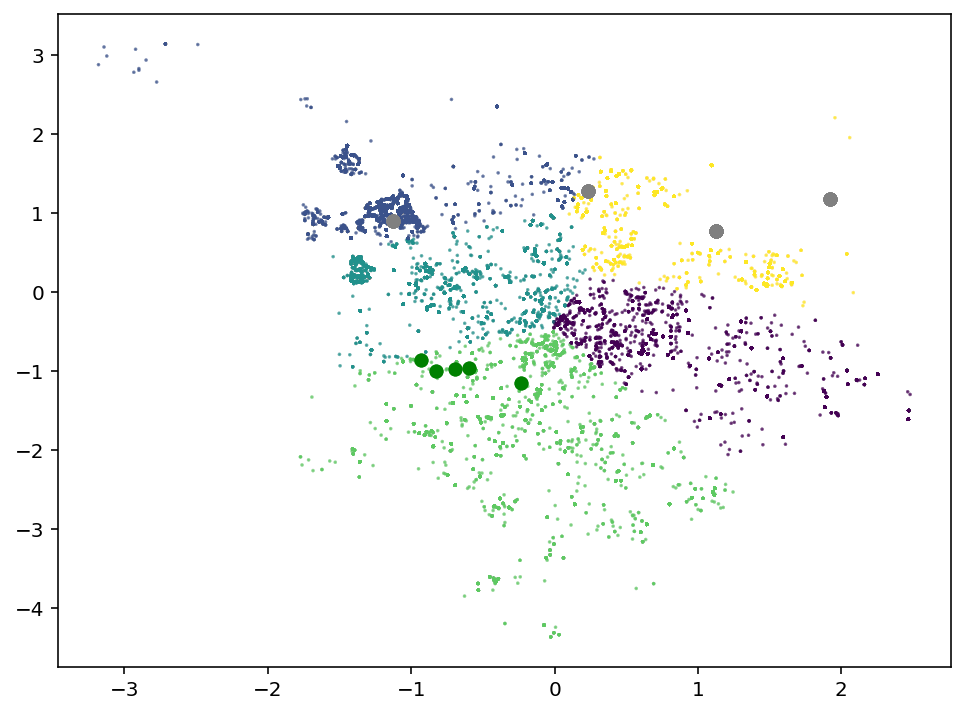

In [259]:
#clustering = DBSCAN(eps=0.2, min_samples=5).fit_predict(data4)

for i,color in zip(range(10),{'blue', 'indigo','red', 'black','green', 'orange','yellow','brown','orchid','lime'}):
    x_i = pd.DataFrame(data_action)[0][labels==i]
    y_i = pd.DataFrame(data_action)[1][labels==i]
    plt.plot(x_i, y_i, 'ro', c=color)
    plt.plot(x_i, y_i, 'ro', c=color)
    
    x_0 = pd.DataFrame(data_action)[0][labels==-1]
    y_0 = pd.DataFrame(data_action)[1][labels==-1]
    plt.plot(x_0, y_0, 'ro', c='grey')
    
    plt.scatter(data2[:,0], data2[:,1], c=kmeans.labels_, s=0.5, alpha=0.1)

Выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [4]:
# Разделим текст по группам: позитивная, негативная

text_p = data[data['comment_class'] == 1].comment
text_n = data[data['comment_class'] == -1].comment

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Urmas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Urmas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [7]:
import re
t_p = []
for i in text_p:
    i = re.sub(r'\xa0', ' ', i)
    t_p.append(re.sub(r'[^А-Яа-яёЁ ]', ' ', i))
    
t_p     

['Не был осведомлен о месте и времени проведения межевания  Не согласен со строительством объекта по адресу  М  Левшенский пер  д    Точечная застройка Москвы запрещена  лучше озеленить этот участок  чтобы было место для прогулок ',
 'Голосую за зону развития по адресу  Новодевичий проезд вл    стр   и Погодинская ул   вл    стр   земельный участок  кад  номер                   для строительства медицинского центра  детского сада жилого многопрофильного дома  общ  наз   площади до      кв м   высотой до       м   с предельн  плотностью застройки до      кв м  на   га территории с обеспечением машиномест и гаражом согласно действующим нормативам с площадью застройки земельного участка до               установить зону развития по адресу   Дашков пер   вл    и ул  Тимура Фрунзе  вл     зем  уч  кад  номер                        и                     для строительства лечебного центра общей наземной площадью до     кв м    высотой до   м и гаражом   до     кв м  с предельной плотностью зас

In [8]:
import re
t_n = []
for i in text_n:
    i = re.sub(r'\xa0', ' ', i)
    t_n.append(re.sub(r'[^А-Яа-яёЁ ]', ' ', i))
    
t_n

['Во все разделы правил землепользования и застройки г Москвы  текстовые части и графические схемы  необходимо внести изменения по земельному участку с кадастровым номером                   с адресом первый Самотёчный пер   вл    Б  в ПЗЗ территориальная зона           и исключить из этого земельного участка часть моей общей долевой собственности   земельного участка многоквартирного дома   А по   му Самотёчному пер  площадью       кв м с точками                                          с координатами           и                                   и                   и                  и                   и                   и                   и                   и                   и                   и                   и                   и               ю   и                   и                   и            На основании вступившего в законную силу судебного решения по делу   А              от            о ничтожности заключённого            договора аренды земельного участка с ад

In [9]:
tokens_p = [i for i in nltk.word_tokenize(str(t_p)) if (i not in stopwords.words('russian'))]
tokens_n = [i for i in nltk.word_tokenize(str(t_n)) if (i not in stopwords.words('russian'))]

Произведем лемматизацию

Лемматизация — процесс приведения словоформы к лемме — её нормальной (словарной) форме. 
В русском языке:
- для существительных — именительный падеж, единственное число;
- для прилагательных — именительный падеж, единственное число, мужской род;
- для глаголов, причастий, деепричастий — глагол в инфинитиве несовершенного вида.

В других языках – по аналогии.

In [10]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
lemmatized_text_p = [wordnet_lemmatizer.lemmatize(word) for word in tokens_p]
lemmatized_text_n = [wordnet_lemmatizer.lemmatize(word) for word in tokens_n]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Urmas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# уберем слова маленькой длины
 
lemmatized_p = list(filter(lambda x: len(x) > 3, lemmatized_text_p))
lemmatized_n = list(filter(lambda x: len(x) > 3, lemmatized_text_n))

In [12]:
# уберем кавычки ''
lemmatized_p = [re.sub(r"['']", '', i) for i in lemmatized_p]
lemmatized_n = [re.sub(r"['']", '', i) for i in lemmatized_n]

In [13]:
# приведем все слова к нижнему регистру
lemmatized_p = [text.lower() for text in lemmatized_p] 
lemmatized_n = [text.lower() for text in lemmatized_n]

In [14]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: smart-open>=1.8.1 in c:\programdata\anaconda3\lib\site-packages (from gensim) (5.0.0)



In [15]:
# https://www.machinelearningplus.com/nlp/gensim-tutorial/
# библиотека gensim позволяет эффективно работать с корпусами текстов
#from gensim.corpora import Dictionary
#import gensim
from gensim import corpora

# создадим словарь, в котором присвоем каждому слову свой уникальный id
dictionary_p = corpora.Dictionary([lemmatized_p])
dictionary_n = corpora.Dictionary([lemmatized_n])

In [16]:
dict(dictionary_p)

{0: 'абельмановская',
 1: 'абрашиной',
 2: 'абсолютная',
 3: 'абсолютно',
 4: 'абуалисович',
 5: 'абульвар',
 6: 'авангардном',
 7: 'аварийно',
 8: 'аварийного',
 9: 'аварийное',
 10: 'аварийной',
 11: 'аварийном',
 12: 'аварийным',
 13: 'аварийных',
 14: 'августа',
 15: 'августе',
 16: 'аверина',
 17: 'авиаконструктора',
 18: 'авиатехснаб',
 19: 'авиаторов',
 20: 'авиационная',
 21: 'авиационной',
 22: 'авиациооная',
 23: 'авиционная',
 24: 'аврийно',
 25: 'автобазы',
 26: 'автобус',
 27: 'автобусами',
 28: 'автобусного',
 29: 'автобусов',
 30: 'автоваз',
 31: 'автовладельцев',
 32: 'автовладельцы',
 33: 'автовокзал',
 34: 'автодорогах',
 35: 'автодороги',
 36: 'автозавода',
 37: 'автозаводская',
 38: 'автозаводский',
 39: 'автозаводской',
 40: 'автозагрузку',
 41: 'автозаправочная',
 42: 'автозаправочной',
 43: 'автозаправочные',
 44: 'автозаправочных',
 45: 'автокомбинат',
 46: 'автомагистрали',
 47: 'автомашин',
 48: 'автомашины',
 49: 'автомобилей',
 50: 'автомобили',
 51: 'автомо

Создадим на основе словаря модель [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model), которая присваивает каждому слову (id) количество его вхождений в конкретном документе

In [17]:
bows_p = [dictionary_p.doc2bow([text]) for text in lemmatized_p]
bows_n = [dictionary_n.doc2bow([text]) for text in lemmatized_n]

In [18]:
bows_p

[[(5723, 1)],
 [(4256, 1)],
 [(1130, 1)],
 [(7665, 1)],
 [(4224, 1)],
 [(9167, 1)],
 [(9641, 1)],
 [(5374, 1)],
 [(118, 1)],
 [(3894, 1)],
 [(9958, 1)],
 [(2681, 1)],
 [(4474, 1)],
 [(2623, 1)],
 [(5539, 1)],
 [(10457, 1)],
 [(4262, 1)],
 [(7702, 1)],
 [(1576, 1)],
 [(2879, 1)],
 [(8146, 1)],
 [(118, 1)],
 [(5054, 1)],
 [(7742, 1)],
 [(6502, 1)],
 [(2805, 1)],
 [(10457, 1)],
 [(5096, 1)],
 [(9635, 1)],
 [(4206, 1)],
 [(10771, 1)],
 [(1952, 1)],
 [(8684, 1)],
 [(2356, 1)],
 [(4370, 1)],
 [(2081, 1)],
 [(6450, 1)],
 [(1360, 1)],
 [(7169, 1)],
 [(6440, 1)],
 [(2684, 1)],
 [(9851, 1)],
 [(5172, 1)],
 [(4178, 1)],
 [(1479, 1)],
 [(9174, 1)],
 [(1880, 1)],
 [(5114, 1)],
 [(6461, 1)],
 [(2684, 1)],
 [(2793, 1)],
 [(10437, 1)],
 [(10335, 1)],
 [(2879, 1)],
 [(8146, 1)],
 [(118, 1)],
 [(1828, 1)],
 [(9905, 1)],
 [(10606, 1)],
 [(5096, 1)],
 [(9635, 1)],
 [(3937, 1)],
 [(10771, 1)],
 [(5332, 1)],
 [(4604, 1)],
 [(6461, 1)],
 [(1360, 1)],
 [(1479, 1)],
 [(7175, 1)],
 [(6440, 1)],
 [(2684, 1)],
 [

In [24]:
word_counts_p = [[(dictionary_p[id], count) for id, count in line] for line in bows_p]
word_counts_n = [[(dictionary_n[id], count) for id, count in line] for line in bows_n]

In [25]:
word_counts_p

[[('осведомлен', 1)],
 [('месте', 1)],
 [('времени', 1)],
 [('проведения', 1)],
 [('межевания', 1)],
 [('согласен', 1)],
 [('строительством', 1)],
 [('объекта', 1)],
 [('адресу', 1)],
 [('левшенский', 1)],
 [('точечная', 1)],
 [('застройка', 1)],
 [('москвы', 1)],
 [('запрещена', 1)],
 [('озеленить', 1)],
 [('участок', 1)],
 [('место', 1)],
 [('прогулок', 1)],
 [('голосую', 1)],
 [('зону', 1)],
 [('развития', 1)],
 [('адресу', 1)],
 [('новодевичий', 1)],
 [('проезд', 1)],
 [('погодинская', 1)],
 [('земельный', 1)],
 [('участок', 1)],
 [('номер', 1)],
 [('строительства', 1)],
 [('медицинского', 1)],
 [('центра', 1)],
 [('детского', 1)],
 [('сада', 1)],
 [('жилого', 1)],
 [('многопрофильного', 1)],
 [('дома', 1)],
 [('площади', 1)],
 [('высотой', 1)],
 [('предельн', 1)],
 [('плотностью', 1)],
 [('застройки', 1)],
 [('территории', 1)],
 [('обеспечением', 1)],
 [('машиномест', 1)],
 [('гаражом', 1)],
 [('согласно', 1)],
 [('действующим', 1)],
 [('нормативам', 1)],
 [('площадью', 1)],
 [('з

In [51]:
# посмотрим на word_counts_ в виде датафрейма
df_p = pd.DataFrame([str(i).strip('[()]').split(',') for i in word_counts_p])
df_p.columns = ['index', 'count']
df_p

index count
0         'осведомлен'     1
1              'месте'     1
2            'времени'     1
3         'проведения'     1
4          'межевания'     1
...                ...   ...
1295004        'домом'     1
1295005        'также'     1
1295006     'повредит'     1
1295007      'зелёным'     1
1295008  'насаждениям'     1

[1295009 rows x 2 columns]

In [54]:
# посмотрим на bow в виде датафрейма
df2_p = pd.DataFrame([str(i).strip('[()]').split(',') for i in bows_p])
df2_n = pd.DataFrame([str(i).strip('[()]').split(',') for i in bows_n])
df2_p

0   1
0        5723   1
1        4256   1
2        1130   1
3        7665   1
4        4224   1
...       ...  ..
1295004  2091   1
1295005  9754   1
1295006  6491   1
1295007  2786   1
1295008  4689   1

[1295009 rows x 2 columns]

In [58]:
df2_p['word'] = [dictionary_p[int(index)] for index in df2_p[0]]
df2_p.columns = ['index', 'count', 'word']
df2_p

index count         word
0        5723     1   осведомлен
1        4256     1        месте
2        1130     1      времени
3        7665     1   проведения
4        4224     1    межевания
...       ...   ...          ...
1295004  2091     1        домом
1295005  9754     1        также
1295006  6491     1     повредит
1295007  2786     1      зелёным
1295008  4689     1  насаждениям

[1295009 rows x 3 columns]

In [59]:
df2_n['word'] = [dictionary_n[int(index)] for index in df2_n[0]]
df2_n.columns = ['index', 'count', 'word']
df2_n

index count              word
0         18985     1           разделы
1         16585     1            правил
2          6494     1  землепользования
3          6160     1         застройки
4         10425     1            москвы
...         ...   ...               ...
21775375   1998     1            вместо
21775376  14506     1             парка
21775377  10638     1          наблюдая
21775378  21893     1          сплошные
21775379   5509     1            заборы

[21775380 rows x 3 columns]

Создадим модель [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (term frequency-inverse document frequency – частотность терминов-обратная частотность документов)

Если слово встречается в каком-либо документе часто, при этом встречаясь редко во всех остальных документах — это слово имеет большую значимость для исхдного документа.

In [63]:
from gensim.models import TfidfModel

tfidf_p = TfidfModel(bows_p)
tfidf_n = TfidfModel(bows_n)

In [73]:
# посмотрим, как это выглядит
tf_p = tfidf_p[bows_p]
tf_n = tfidf_n[bows_n]

In [89]:
list(tf_p)

[[(5723, 1.0)],
 [(4256, 1.0)],
 [(1130, 1.0)],
 [(7665, 1.0)],
 [(4224, 1.0)],
 [(9167, 1.0)],
 [(9641, 1.0)],
 [(5374, 1.0)],
 [(118, 1.0)],
 [(3894, 1.0)],
 [(9958, 1.0)],
 [(2681, 1.0)],
 [(4474, 1.0)],
 [(2623, 1.0)],
 [(5539, 1.0)],
 [(10457, 1.0)],
 [(4262, 1.0)],
 [(7702, 1.0)],
 [(1576, 1.0)],
 [(2879, 1.0)],
 [(8146, 1.0)],
 [(118, 1.0)],
 [(5054, 1.0)],
 [(7742, 1.0)],
 [(6502, 1.0)],
 [(2805, 1.0)],
 [(10457, 1.0)],
 [(5096, 1.0)],
 [(9635, 1.0)],
 [(4206, 1.0)],
 [(10771, 1.0)],
 [(1952, 1.0)],
 [(8684, 1.0)],
 [(2356, 1.0)],
 [(4370, 1.0)],
 [(2081, 1.0)],
 [(6450, 1.0)],
 [(1360, 1.0)],
 [(7169, 1.0)],
 [(6440, 1.0)],
 [(2684, 1.0)],
 [(9851, 1.0)],
 [(5172, 1.0)],
 [(4178, 1.0)],
 [(1479, 1.0)],
 [(9174, 1.0)],
 [(1880, 1.0)],
 [(5114, 1.0)],
 [(6461, 1.0)],
 [(2684, 1.0)],
 [(2793, 1.0)],
 [(10437, 1.0)],
 [(10335, 1.0)],
 [(2879, 1.0)],
 [(8146, 1.0)],
 [(118, 1.0)],
 [(1828, 1.0)],
 [(9905, 1.0)],
 [(10606, 1.0)],
 [(5096, 1.0)],
 [(9635, 1.0)],
 [(3937, 1.0)],
 [(10

In [1]:
for i in tf_p:
    print(re.sub(r'[[[(())]]', '', str(i)))

NameError: name 'tf_p' is not defined

In [ ]:
df2_p['tfidf'] = [ for index in df2_p[0]]
df2_p.columns = ['index', 'count', 'word']
df2_p

In [74]:
from gensim import similarities
sim_p = similarities.MatrixSimilarity(list(tf_p))
# преобразуем в датафрейм
sim_df_p = pd.DataFrame(list(sim_p))

MemoryError: Unable to allocate 53.7 GiB for an array with shape (1295009, 11137) and data type float32

In [76]:
# большая нагрузка на ПК, только для положительных отзывов
from gensim.models.ldamodel import LdaModel
justlda_p = LdaModel(
    corpus=bows_p, num_topics=4, passes=30
)

In [85]:
for i in range(4):
    terms = justlda_p.get_topic_terms(i)
    #print(i, ' '.join(map(lambda x: bows_p.dictionary.get([x[0]]), terms)))
    print(terms)

[(7083, 0.05551298), (2825, 0.054700766), (9851, 0.046277136), (6547, 0.04524424), (7783, 0.03203504), (4464, 0.026418488), (10802, 0.02290706), (7755, 0.02200201), (10437, 0.020396682), (8247, 0.019652471)]
[(118, 0.14448293), (7754, 0.08858055), (5584, 0.04760607), (7814, 0.017855486), (7433, 0.017378043), (2356, 0.016661292), (7994, 0.014173357), (3889, 0.011444357), (814, 0.011184449), (4915, 0.010246141)]
[(4474, 0.07944787), (9635, 0.03292242), (2561, 0.026143173), (4524, 0.02439801), (2081, 0.023745576), (8022, 0.020552656), (7561, 0.020258425), (5505, 0.018392935), (6774, 0.016054815), (9035, 0.015950669)]
[(2684, 0.08197892), (1598, 0.044521544), (7810, 0.036323875), (1662, 0.021869257), (3678, 0.017742094), (7201, 0.01708742), (1562, 0.015923616), (2367, 0.013376087), (8284, 0.013045706), (5548, 0.012950379)]


In [87]:
for i in range(4):
    terms = justlda_p.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: dictionary_p[x[0]], terms)))

0 правил землепользования территории поддерживаю проектом москва части проекта участка разрешенного
1 адресу проект округа проживающая приведет жилого прошу лациса вилиса необходимым
2 москвы строительства замечания муниципального дома публичных принятие одобряю полностью слушаний
3 застройки города проживаю гпзу корп предложения года жилых района ознакомилась


не удается доделать до конца задание, виснет ПК и вылетает программа вторые сутки:((
мне хотелось бы склеить в один датасет df2_n(p) все данные (добавить еще tf_n(p), сделать фильтр на самые употребляемые слова, ... никак